# Sentiment Analysis

## Description
Perform sentiment analysis.

## Setup

### Libraries (Pyhton)

In [ ]:
import igraph as ig
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
from pathlib import Path
import sys
import copy
from IPython.display import SVG
from sknetwork.ranking import PageRank
from sknetwork.visualization import visualize_graph
from scipy.sparse import csr_matrix

### Directories

In [5]:
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    BASE_DIR = Path().resolve()

SRC_DIR = BASE_DIR / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

DATA_DIR = BASE_DIR / 'data'
DATA_DIR.mkdir(exist_ok=True)
POSTS_DIR = DATA_DIR / 'posts'
POSTS_ALL_DIR = POSTS_DIR / 'all'
POSTS_FILTERED_DIR = POSTS_DIR / 'filtered'
POSTS_FILTERED_CLEAN_DIR = POSTS_FILTERED_DIR / 'clean'
COMMENTS_DIR = DATA_DIR / 'comments'
COMMENTS_CLEAN_DIR = COMMENTS_DIR / 'clean'
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_GRAPHS_DIR = RESULTS_DIR / 'graphs'
RESULTS_MODELS_DIR = RESULTS_DIR / 'models'
RESULTS_MODELS_DIR.mkdir(exist_ok=True)
RESULTS_MODELS_FILE = RESULTS_MODELS_DIR / 'model_results.csv'

### Libraries (Custom)

In [69]:
import topic as t

## Import Data

In [7]:
# Graph
filename = RESULTS_GRAPHS_DIR / 'g_dd.graphml'
g_dd_nx = nx.read_graphml(str(filename))
g_dd = ig.Graph.from_networkx(g_dd_nx)

print(g_dd.summary())

IGRAPH UNW- 15819 924974 -- 
+ attr: edge_default (g), node_default (g), _nx_name (v), name (v), weight (e)


In [8]:
# Matrices
filename_pickle_gdd = RESULTS_GRAPHS_DIR / 'g_dd.pickle'
with open(filename_pickle_gdd , 'rb') as f:
    g_dd_matrices = pickle.load(f)

In [9]:
# Original documents
filename_df = DATA_DIR / 'df_dd.json'
df_dd = pd.read_json(str(filename_df), lines=True)
leiden_topics = list(df_dd['leiden_topic'])

In [10]:
# LIWC-22 Results
cols_in = ['document_id', 'leiden_topic', 'tone_pos', 'tone_neg', 'emo_pos', 'emo_neg', 'politic', 'health', 'mental']
filename_liwc_results = RESULTS_MODELS_DIR / 'liwc-22' / 'liwc-22-results.csv'
df = pd.read_csv(filename_liwc_results, usecols=cols_in)

In [11]:
# BERTAgent scores
filename_bertagent_scores = RESULTS_MODELS_DIR / 'bertagent' / 'data' / 'bertagent_scores.json'
with open(filename_bertagent_scores, "r", encoding="utf-8-sig") as f:
    bertagent_scores = json.load(f)
bertagent_scores_int = {int(k): v for k, v in bertagent_scores.items()}

## Preprocess Text for BERTAgent
For efficiency, extract only the first 15 top documents per topic.

In [ ]:
# Get top 15 documents per topic
repr_docs_idx_leiden = t.get_louvain_community_reps(g_dd, leiden_topics, top_k=15)
doc_id_to_text = dict(zip(df_dd['document_id'], df_dd['og_text']))

# Build the new dictionary
repr_docs_text_leiden = {
    topic: [doc_id_to_text[doc_id] for doc_id in doc_ids if doc_id in doc_id_to_text]
    for topic, doc_ids in repr_docs_idx_leiden.items()
}

In [17]:
# Flatten the dictionary into a list of dicts, removing outlier topics
rows = [
    {"leiden_topic": topic, "text": text}
    for topic, texts in repr_docs_text_leiden.items() if topic<=12
    for text in texts
]

# Create the DataFrame
df_repr_docs = pd.DataFrame(rows)

In [18]:
# Save to .csv
filename_repr_docs = RESULTS_MODELS_DIR / 'bertagent' / 'data' / 'repr_docs.csv'
df_repr_docs['text'] = df_repr_docs['text'].astype(str)
df_repr_docs.to_csv(filename_repr_docs, index=False, encoding='utf-8-sig')

## LIWC-22 Analysis

In [12]:
# Calculate composite "positive emotion" score
df["emotion"] = df["emo_pos"] - df["emo_neg"]

# Calculate composite "tone" score
df["tone"] = df["tone_pos"] - df["tone_neg"]

# Map BERTAgent scores to topic
df['agency'] = df['leiden_topic'].map(bertagent_scores_int)

In [13]:
# Assign attributes from LIWC-22 and BERTAgent to nodes
attributes_to_assign = [
    'leiden_topic', 'emotion', 'tone', 'mental', 'health',
    'politic', 'agency'
]

# Create a lookup dictionary from the DataFrame
df_copy = copy.deepcopy(df)
df_copy.set_index('document_id', inplace=True)
attr_dict = df_copy[attributes_to_assign].to_dict(orient='index')

# Iterate over nodes and assign attributes
for v in g_dd.vs:
    doc_id = v['name']
    if doc_id in attr_dict:
        for attr, value in attr_dict[doc_id].items():
            v[attr] = value
    else:
        print(f"Warning: document_id {doc_id} not found in DataFrame.")

In [11]:
# Save to graphml
filename_graph = RESULTS_GRAPHS_DIR / 'sentiment_graph.graphml'
g_dd.write_graphml(str(filename_graph))

### Build Topic Graph

In [23]:
# Extract C
topics = list(df['leiden_topic'])
num_docs, num_topics, C = t.extract_community_assignments(topics, topic_ids_start=1)

In [24]:
# Normalize existing matrices
Pwd = g_dd_matrices['Pwd'] / g_dd_matrices['Pwd'].sum()
Pdd = g_dd_matrices['Pdd'] / g_dd_matrices['Pdd'].sum()

In [25]:
# Update topic matrices
Pwc = Pwd.dot(C)              # Joint word + class probability
Pcc = ((C.T).dot(Pdd)).dot(C) # Joint class + class probability
pc = Pcc.sum(axis=0)          # Topic co-occurrence weights (node strength of each topic in the topic co-occurrence matrix)

In [26]:
# Load custom topic labels
filename_leiden_custom_topics = RESULTS_MODELS_DIR / 'leiden' / 'custom_topics_sorted.json'
with open(filename_leiden_custom_topics, 'r') as f:
    custom_topic_labels = json.load(f)

labs = {str(k): v for k, v in custom_topic_labels.items()}

In [27]:
# List of metrics to aggregate
metrics = ['politic', 'mental', 'health', 'emotion', 'tone', 'agency']

# Group by topic and compute means
topic_df = df.groupby('leiden_topic')[metrics].mean().reset_index()
topic_df['node_strength'] = np.array(pc)[0]
topic_df['agency'] = topic_df['agency'].fillna(0.0)
topic_df['topic_label'] = topic_df['leiden_topic'].astype(str).map(labs)

# Ignore outlier data
mask = topic_df['topic_label'].str.contains('Outliers', na=False)
cols_to_zero = topic_df.columns.difference(['leiden_topic', 'topic_label'])
topic_df.loc[mask, cols_to_zero] = 0.0

In [28]:
# Number of topics
n_topics = Pcc.shape[0]

# Create a graph with n_topics nodes
g_topic = ig.Graph()
g_topic.add_vertices(n_topics)

# Add node attribute: topic ID
g_topic.vs['leiden_topic'] = list(range(n_topics))

# Set mean attributes on each topic node
attributes = [col for col in topic_df.columns if col != 'leiden_topic']
for attr in attributes:
    # Map from leiden_topic -> value
    values = topic_df.set_index('leiden_topic')[attr]
    g_topic.vs[attr] = [values.get(t, None) for t in g_topic.vs['leiden_topic']]

# Build edges from upper triangle of the Pcc matrix (symmetric)
edges = []
weights = []

for i in range(n_topics):
    for j in range(i+1, n_topics):
        weight = Pcc[i, j]
        if weight > 0.0:  # Only keep non-zero edges
            edges.append((i, j))
            weights.append(weight)

# Add edges and their weights
g_topic.add_edges(edges)
g_topic.es['weight'] = weights

### PageRank Centrality

#### Weighted

In [76]:
# Normalize rows to get the transition matrix
Pcc_dense = Pcc.toarray()
row_sums_weighted = Pcc_dense.sum(axis=1, keepdims=True)
A_weighted = Pcc_dense / row_sums_weighted

In [ ]:
# Compute PageRank entrality
pagerank_weighted = PageRank()
scores_weighted = pagerank_weighted.fit_predict(A_weighted)
topic_df['pagerank_weighted'] = scores_weighted

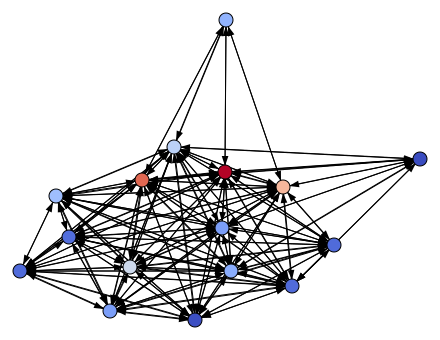

In [79]:
# Plot
layout_weighted = g_topic.layout_fruchterman_reingold()
position_weighted = np.array(layout_weighted.coords)

A_sparse_weighted = csr_matrix(A_weighted)
image = visualize_graph(A_sparse_weighted, position_weighted, scores=np.log(scores_weighted))
SVG(image)

#### Unweighted

In [ ]:
# Compute PageRank entrality
A = np.array(g_topic.get_adjacency())
pagerank = PageRank()
scores = pagerank.fit_predict(A)
topic_df['pagerank_unweighted'] = scores

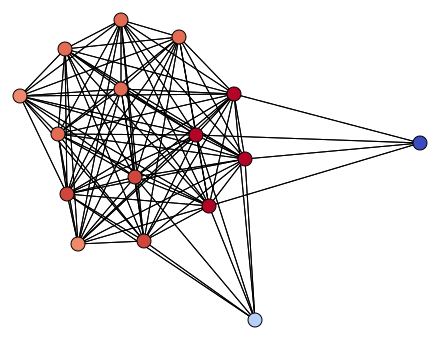

In [83]:
# Plot
layout = g_topic.layout_fruchterman_reingold()
position = np.array(layout.coords)

A_sparse = csr_matrix(A)
image = visualize_graph(A_sparse, position, scores=np.log(scores))
SVG(image)

### Build Sentiment Graph with PageRank

In [ ]:
# Number of topics
n_topics = Pcc.shape[0]

# Create a graph with n_topics nodes
g_topic_pr = ig.Graph()
g_topic_pr.add_vertices(n_topics)

# Add node attribute: topic ID
g_topic_pr.vs['leiden_topic'] = list(range(n_topics))

# Set mean attributes on each topic node
attributes = [col for col in topic_df.columns if col != 'leiden_topic']
for attr in attributes:
    # Map from leiden_topic -> value
    values = topic_df.set_index('leiden_topic')[attr]
    g_topic_pr.vs[attr] = [values.get(t, None) for t in g_topic_pr.vs['leiden_topic']]

# Build edges from upper triangle of the Pcc matrix (symmetric)
edges = []
weights = []

for i in range(n_topics):
    for j in range(i+1, n_topics):
        weight = Pcc[i, j]
        if weight > 0.0:  # Only keep non-zero edges
            edges.append((i, j))
            weights.append(weight)

# Add edges and their weights
g_topic_pr.add_edges(edges)
g_topic_pr.es['weight'] = weights

In [ ]:
# Save to graphml
filename_topic_graph = RESULTS_GRAPHS_DIR / 'topics_graph.graphml'
g_topic_pr.write_graphml(str(filename_topic_graph))

In [ ]:
# Save to csv
filename_topic_df = DATA_DIR / 'topic_df.csv'
topic_df.to_csv(filename_topic_df, index=False, encoding='utf-8-sig')

## Clear Allocated Memory

In [ ]:
# Run before exiting the program to clear memory
%reset -f
import gc
gc.collect()